<a href="https://colab.research.google.com/github/Thunyawat2543/football/blob/main/mini_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
import sqlite3
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
from google.colab import files

uploaded = files.upload()


Saving database.sqlite.zip to database.sqlite (1).zip


แตกไฟล์

In [11]:
!unzip database.sqlite.zip

Archive:  database.sqlite.zip
replace database.sqlite? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: database.sqlite         


HEAD DATA

In [12]:
conn = sqlite3.connect('/content/database.sqlite')
df_player = pd.read_sql_query("SELECT * FROM Player", conn)
df_player.head()

,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


In [13]:
df_player = pd.read_sql_query("SELECT * FROM Player", conn)
df_match = pd.read_sql_query("SELECT * FROM Match", conn)
print(df_player.head())
print(df_match.head())

   id  player_api_id         player_name  player_fifa_api_id  \
0   1         505942  Aaron Appindangoye              218353   
1   2         155782     Aaron Cresswell              189615   
2   3         162549         Aaron Doran              186170   
3   4          30572       Aaron Galindo              140161   
4   5          23780        Aaron Hughes               17725   

              birthday  height  weight  
0  1992-02-29 00:00:00  182.88     187  
1  1989-12-15 00:00:00  170.18     146  
2  1991-05-13 00:00:00  170.18     163  
3  1982-05-08 00:00:00  182.88     198  
4  1979-11-08 00:00:00  182.88     154  
   id  country_id  league_id     season  stage                 date  \
0   1           1          1  2008/2009      1  2008-08-17 00:00:00   
1   2           1          1  2008/2009      1  2008-08-16 00:00:00   
2   3           1          1  2008/2009      1  2008-08-16 00:00:00   
3   4           1          1  2008/2009      1  2008-08-17 00:00:00   
4   5         

ค้นหา player_api_id ของ Lionel Messi

In [ ]:
df_match = pd.read_sql_query("SELECT * FROM Match", conn)

def get_winner(row):
    if row['home_team_goal'] > row['away_team_goal']:
        return row['home_team_api_id']
    elif row['away_team_goal'] > row['home_team_goal']:
        return row['away_team_api_id']
    else:
        return None

df_match['winner_id'] = df_match.apply(get_winner, axis=1)

win_count = df_match['winner_id'].value_counts().reset_index()
win_count.columns = ['team_api_id', 'wins']


win_count = win_count.merge(df_team[['team_api_id', 'team_long_name']], on='team_api_id', how='left')


win_count_sorted = win_count.sort_values(by='wins', ascending=False)
top_5 = win_count_sorted.head(5)

print("5 ทีมที่ชนะบ่อยที่สุด (เรียงจากมากไปน้อย):")
print(top_5[['team_long_name', 'wins']].to_string(index=False))

5 ทีมที่ชนะบ่อยที่สุด (เรียงจากมากไปน้อย):
   team_long_name  wins
     FC Barcelona   234
   Real Madrid CF   228
           Celtic   218
 FC Bayern Munich   193
Manchester United   192


In [ ]:
df_team = pd.read_sql_query("SELECT * FROM Team", conn)
df_player = pd.read_sql_query("SELECT * FROM Player", conn)
df_match = pd.read_sql_query("SELECT * FROM Match", conn)

barca_row = df_team[df_team['team_long_name'] == 'FC Barcelona']
if barca_row.empty:
    raise ValueError("ไม่พบชื่อทีม 'FC Barcelona' ในตาราง Team")
barca_id = barca_row['team_api_id'].values[0]

messi_row = df_player[df_player['player_name'] == 'Lionel Messi']
if messi_row.empty:
    raise ValueError("ไม่พบผู้เล่น 'Lionel Messi' ในตาราง Player")
messi_id = messi_row['player_api_id'].values[0]

barca_matches = df_match[
    (df_match['home_team_api_id'] == barca_id) |
    (df_match['away_team_api_id'] == barca_id)
].copy()


def is_barca_win(row):
    home_goals = row['home_team_goal']
    away_goals = row['away_team_goal']
    home_id = row['home_team_api_id']
    away_id = row['away_team_api_id']

    if home_id == barca_id and home_goals > away_goals:
        return 1

    elif away_id == barca_id and away_goals > home_goals:
        return 1
    else:
        return 0

barca_matches['barca_win'] = barca_matches.apply(is_barca_win, axis=1)

player_cols = [f'home_player_{i}' for i in range(1, 12)] + [f'away_player_{i}' for i in range(1, 12)]

messi_barca_matches = barca_matches[barca_matches[player_cols].isin([messi_id]).any(axis=1)].copy()
non_messi_barca_matches = barca_matches[~barca_matches.index.isin(messi_barca_matches.index)].copy()

win_rate_messi = messi_barca_matches['barca_win'].mean()
win_rate_non_messi = non_messi_barca_matches['barca_win'].mean()

print("จำนวนแมตช์ Barcelona ที่มี Messi ลงเล่น:", len(messi_barca_matches))
print("Win Rate (มี Messi): {:.2f}".format(win_rate_messi))
print("จำนวนแมตช์ Barcelona ที่ไม่มี Messi:", len(non_messi_barca_matches))
print("Win Rate (ไม่มี Messi): {:.2f}".format(win_rate_non_messi))

จำนวนแมตช์ Barcelona ที่มี Messi ลงเล่น: 249
Win Rate (มี Messi): 0.78
จำนวนแมตช์ Barcelona ที่ไม่มี Messi: 55
Win Rate (ไม่มี Messi): 0.73


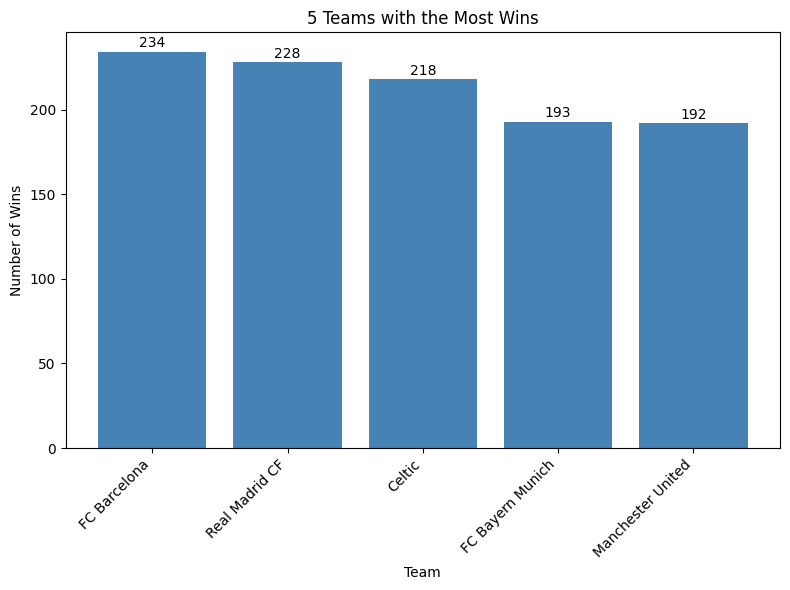

In [ ]:
data = {
    'team_long_name': [
        'FC Barcelona',
        'Real Madrid CF',
        'Celtic',
        'FC Bayern Munich',
        'Manchester United'
    ],
    'wins': [234, 228, 218, 193, 192]
}

df_top5 = pd.DataFrame(data)

plt.figure(figsize=(8, 6))

bars = plt.bar(df_top5['team_long_name'], df_top5['wins'], color='steelblue')

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1,
        f'{height}',
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.title('5 Teams with the Most Wins')
plt.xlabel('Team')
plt.ylabel('Number of Wins')

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [ ]:
barca_row = df_team[df_team['team_long_name'] == 'FC Barcelona']
if barca_row.empty:
    raise ValueError("ไม่พบชื่อทีม 'FC Barcelona' ในตาราง Team")
barca_id = barca_row['team_api_id'].values[0]
barca_matches = df_match[
    (df_match['home_team_api_id'] == barca_id) |
    (df_match['away_team_api_id'] == barca_id)
].copy()

def is_barca_win(row):
    home_goals = row['home_team_goal']
    away_goals = row['away_team_goal']
    home_id = row['home_team_api_id']
    away_id = row['away_team_api_id']


    if home_id == barca_id and home_goals > away_goals:
        return 1

    elif away_id == barca_id and away_goals > home_goals:
        return 1
    else:
        return 0

barca_matches['barca_win'] = barca_matches.apply(is_barca_win, axis=1)

win_percentage = barca_matches['barca_win'].mean() * 100

print(f"จำนวนแมตช์ที่ Barcelona ลงแข่งทั้งหมด: {len(barca_matches)}")
print(f"เปอร์เซ็นต์การชนะของ Barcelona: {win_percentage:.2f}%")


จำนวนแมตช์ที่ Barcelona ลงแข่งทั้งหมด: 304
เปอร์เซ็นต์การชนะของ Barcelona: 76.97%


       season   team_long_name  total_points  rank
2   2008/2009     FC Barcelona            87   1.0
1   2008/2009   Real Madrid CF            78   2.0
0   2008/2009       Sevilla FC            70   3.0
4   2009/2010     FC Barcelona            99   1.0
3   2009/2010   Real Madrid CF            96   2.0
5   2009/2010      Valencia CF            71   3.0
7   2010/2011     FC Barcelona            96   1.0
6   2010/2011   Real Madrid CF            92   2.0
8   2010/2011      Valencia CF            71   3.0
9   2011/2012   Real Madrid CF           100   1.0
10  2011/2012     FC Barcelona            91   2.0
11  2011/2012      Valencia CF            61   3.0
13  2012/2013     FC Barcelona           100   1.0
12  2012/2013   Real Madrid CF            85   2.0
14  2012/2013  Atlético Madrid            76   3.0
17  2013/2014  Atlético Madrid            90   1.0
15  2013/2014   Real Madrid CF            87   2.0
16  2013/2014     FC Barcelona            87   3.0
19  2014/2015     FC Barcelona 

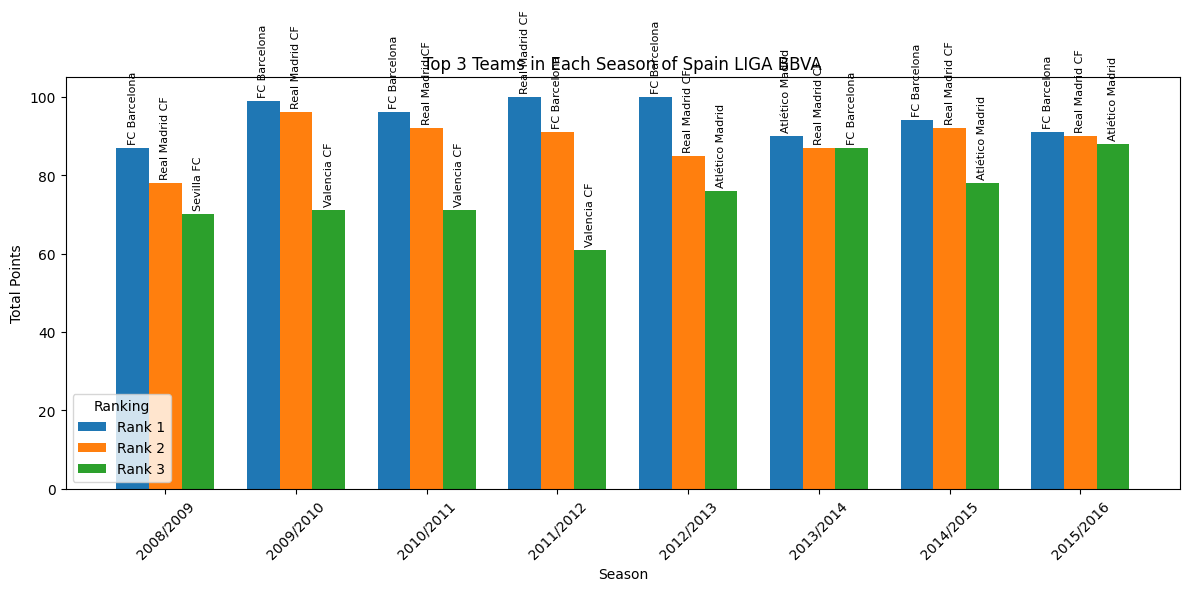

In [ ]:
df_league = pd.read_sql_query("SELECT * FROM League", conn)
df_match  = pd.read_sql_query("SELECT * FROM Match", conn)
df_team   = pd.read_sql_query("SELECT * FROM Team", conn)
df_spain_league = df_league[df_league['name'] == "Spain LIGA BBVA"]
if df_spain_league.empty:
    print("ไม่พบข้อมูลลีก Spain LIGA BBVA")
else:
    spain_league_id = df_spain_league.iloc[0]['id']

    df_spain = df_match[df_match['league_id'] == spain_league_id].copy()

    df_spain['home_points'] = df_spain.apply(
        lambda row: 3 if row['home_team_goal'] > row['away_team_goal']
                    else (1 if row['home_team_goal'] == row['away_team_goal'] else 0),
        axis=1
    )
    df_spain['away_points'] = df_spain.apply(
        lambda row: 3 if row['away_team_goal'] > row['home_team_goal']
                    else (1 if row['away_team_goal'] == row['home_team_goal'] else 0),
        axis=1
    )

    home_points = df_spain.groupby(['season', 'home_team_api_id'])['home_points'].sum().reset_index()
    home_points.rename(columns={'home_team_api_id': 'team_api_id'}, inplace=True)

    away_points = df_spain.groupby(['season', 'away_team_api_id'])['away_points'].sum().reset_index()
    away_points.rename(columns={'away_team_api_id': 'team_api_id'}, inplace=True)

    df_points = pd.merge(home_points, away_points, on=['season', 'team_api_id'], how='outer').fillna(0)
    df_points['total_points'] = df_points['home_points'] + df_points['away_points']
    df_points['rank'] = df_points.groupby('season')['total_points'].rank(method='first', ascending=False)
    df_top3 = df_points[df_points['rank'] <= 3].copy()
    df_top3 = pd.merge(df_top3, df_team[['team_api_id', 'team_long_name']], on='team_api_id', how='left')
    df_top3.sort_values(['season', 'rank'], inplace=True)
    print(df_top3[['season', 'team_long_name', 'total_points', 'rank']])

    seasons = df_top3['season'].unique()
    x_positions = np.arange(len(seasons))
    width = 0.25

    fig, ax = plt.subplots(figsize=(12, 6))
    for i, r in enumerate([1, 2, 3]):
        df_rank = df_top3[df_top3['rank'] == r].copy()

        df_rank = df_rank.set_index('season').reindex(seasons).reset_index()

        bars = ax.bar(x_positions + i*width, df_rank['total_points'], width=width, label=f"Rank {int(r)}")
        for j, row in df_rank.iterrows():
            if pd.notna(row['total_points']):
                ax.text(x_positions[j] + i*width, row['total_points'] + 1,
                        row['team_long_name'],
                        ha='center', va='bottom', fontsize=8, rotation=90)

    ax.set_xticks(x_positions + width)
    ax.set_xticklabels(seasons, rotation=45)
    ax.set_xlabel("Season")
    ax.set_ylabel("Total Points")
    ax.set_title("Top 3 Teams in Each Season of Spain LIGA BBVA")
    ax.legend(title="Ranking")
    plt.tight_layout()
    plt.show()




Coefficient (slope): -0.17857142857142866
Intercept: 452.3214285714287


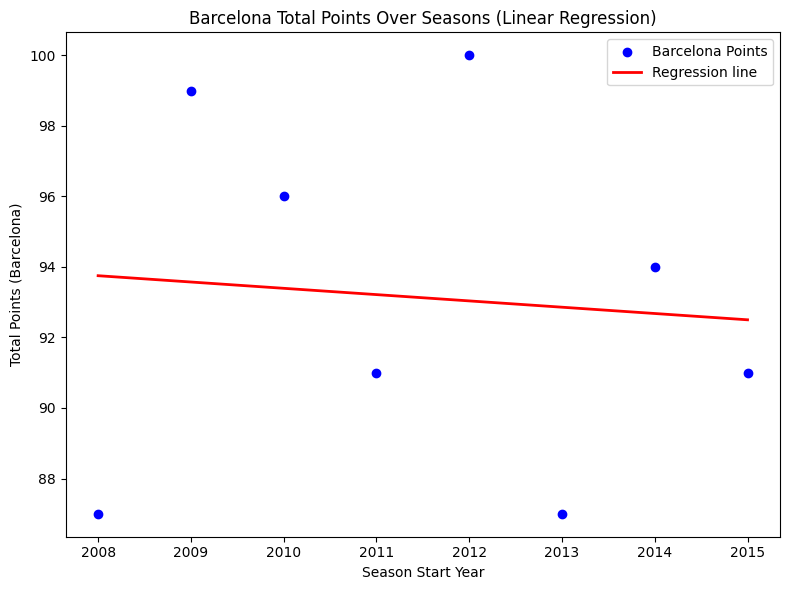

In [ ]:
df_league = pd.read_sql_query("SELECT * FROM League", conn)
df_match  = pd.read_sql_query("SELECT * FROM Match", conn)
df_team   = pd.read_sql_query("SELECT * FROM Team", conn)

df_spain_league = df_league[df_league['name'] == "Spain LIGA BBVA"]
if df_spain_league.empty:
    raise ValueError("ไม่พบข้อมูลลีก Spain LIGA BBVA")
spain_league_id = df_spain_league.iloc[0]['id']

df_spain = df_match[df_match['league_id'] == spain_league_id].copy()

df_spain['home_points'] = df_spain.apply(
    lambda row: 3 if row['home_team_goal'] > row['away_team_goal']
                else (1 if row['home_team_goal'] == row['away_team_goal'] else 0),
    axis=1
)
df_spain['away_points'] = df_spain.apply(
    lambda row: 3 if row['away_team_goal'] > row['home_team_goal']
                else (1 if row['away_team_goal'] == row['home_team_goal'] else 0),
    axis=1
)

home_points = df_spain.groupby(['season', 'home_team_api_id'])['home_points'].sum().reset_index()
home_points.rename(columns={'home_team_api_id': 'team_api_id'}, inplace=True)

away_points = df_spain.groupby(['season', 'away_team_api_id'])['away_points'].sum().reset_index()
away_points.rename(columns={'away_team_api_id': 'team_api_id'}, inplace=True)

df_points = pd.merge(home_points, away_points, on=['season', 'team_api_id'], how='outer').fillna(0)
df_points['total_points'] = df_points['home_points'] + df_points['away_points']

barca_row = df_team[df_team['team_long_name'] == 'FC Barcelona']
if barca_row.empty:
    raise ValueError("ไม่พบทีม FC Barcelona ในตาราง Team")
barca_id = barca_row.iloc[0]['team_api_id']
df_barca = df_points[df_points['team_api_id'] == barca_id].copy()

def season_to_year(season_str):
    return int(season_str.split('/')[0])

df_barca['start_year'] = df_barca['season'].apply(season_to_year)

X = df_barca[['start_year']].values
y = df_barca['total_points'].values

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

print("Coefficient (slope):", model.coef_[0])
print("Intercept:", model.intercept_)


plt.figure(figsize=(8, 6))
plt.scatter(df_barca['start_year'], df_barca['total_points'], color='blue', label='Barcelona Points')
plt.plot(df_barca['start_year'], y_pred, color='red', linewidth=2, label='Regression line')
plt.xlabel("Season Start Year")
plt.ylabel("Total Points (Barcelona)")
plt.title("Barcelona Total Points Over Seasons (Linear Regression)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
messi = df_player[df_player['player_name'] == 'Lionel Messi']
if not messi.empty:
    messi_id = messi['player_api_id'].values[0]
    print("Messi ID:", messi_id)
else:
    print("ไม่พบข้อมูลของ Lionel Messi ในตาราง Player")

Messi ID: 30981


In [ ]:
df_player_attr = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)
df_player_attr['date'] = pd.to_datetime(df_player_attr['date'])

start_date = '2008-01-01'
end_date = '2016-12-31'
mask = (df_player_attr['date'] >= start_date) & (df_player_attr['date'] <= end_date)
df_filtered = df_player_attr[mask].copy()


df_rating_mean = (df_filtered
                  .groupby('player_api_id')['overall_rating']
                  .mean()
                  .reset_index()
                  .rename(columns={'overall_rating': 'avg_overall_rating'}))


df_rating_mean_sorted = df_rating_mean.sort_values(by='avg_overall_rating', ascending=False)
top_5_players = df_rating_mean_sorted.head(5)


top_5_players = top_5_players.merge(
    df_player[['player_api_id', 'player_name']],
    on='player_api_id',
    how='left'
)

print("5 นักเตะที่เก่งที่สุด (ค่าคะแนน Overall Rating เฉลี่ยสูงสุด) ช่วงปี 2008-2016:")
print(top_5_players[['player_name', 'avg_overall_rating']])

5 นักเตะที่เก่งที่สุด (ค่าคะแนน Overall Rating เฉลี่ยสูงสุด) ช่วงปี 2008-2016:
          player_name  avg_overall_rating
0        Lionel Messi           92.750000
1   Cristiano Ronaldo           91.478261
2      Andres Iniesta           88.739130
3       Franck Ribery           88.636364
4  Zlatan Ibrahimovic           88.421053


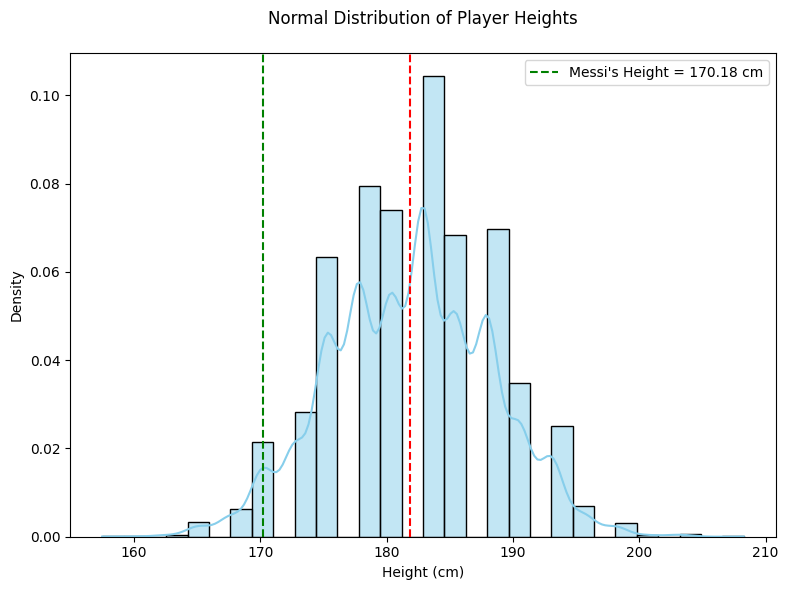

In [ ]:
df_player = pd.read_sql_query("SELECT * FROM Player", conn)
all_heights = df_player['height'].dropna()
messi_data = df_player[df_player['player_name'] == 'Lionel Messi']
if not messi_data.empty:
    messi_height = messi_data['height'].values[0]
else:
    print("ไม่พบข้อมูลความสูงของ Lionel Messi ในตาราง Player")
    messi_height = None
mu = all_heights.mean()
sigma = all_heights.std()
plt.figure(figsize=(8, 6))
sns.histplot(all_heights, kde=True, color='skyblue', bins=30, stat='density')
plt.axvline(x=mu, color='red', linestyle='--')

if messi_height is not None:
    plt.axvline(x=messi_height, color='green', linestyle='--', label=f"Messi's Height = {messi_height} cm")

plt.title('Normal Distribution of Player Heights\n')
plt.xlabel('Height (cm)')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df_league = pd.read_sql_query("SELECT * FROM League", conn)
df_match = pd.read_sql_query("SELECT * FROM Match", conn)
df_player = pd.read_sql_query("SELECT * FROM Player", conn)
df_player_attr = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)

target_leagues = [
    "England Premier League",
    "Spain LIGA BBVA",
    "Belgium Jupiler League",
    "Germany 1. Bundesliga",
    "Italy Serie A"
]
def find_best_player_in_league(league_name):

    row = df_league[df_league['name'] == league_name]
    if row.empty:
        return None, None
    league_country_id = row['country_id'].values[0]

    league_matches = df_match[df_match['country_id'] == league_country_id]

    player_cols = [f'home_player_{i}' for i in range(1, 12)] + [f'away_player_{i}' for i in range(1, 12)]

    league_player_ids = pd.unique(league_matches[player_cols].values.ravel('K'))

    league_player_ids = league_player_ids[~pd.isnull(league_player_ids)].astype(int)

    if len(league_player_ids) == 0:
        return None, None
    df_attr_league = df_player_attr[df_player_attr['player_api_id'].isin(league_player_ids)]

    if df_attr_league.empty:
        return None, None

    df_max_rating = (df_attr_league
                     .groupby('player_api_id')['overall_rating']
                     .max()
                     .reset_index(name='max_rating'))
    best_row = df_max_rating.loc[df_max_rating['max_rating'].idxmax()]
    best_player_id = best_row['player_api_id']
    best_rating = best_row['max_rating']

    row_player = df_player[df_player['player_api_id'] == best_player_id]
    if not row_player.empty:
        best_player_name = row_player['player_name'].values[0]
    else:
        best_player_name = str(best_player_id)

    return best_player_name, best_rating

results = []
for league in target_leagues:
    player_name, rating = find_best_player_in_league(league)
    results.append({
        'league': league,
        'best_player': player_name if player_name else 'Not found',
        'best_rating': rating if rating else 'N/A'
    })

df_results = pd.DataFrame(results)
print(df_results)


                   league       best_player  best_rating
0  England Premier League      Wayne Rooney         93.0
1         Spain LIGA BBVA      Lionel Messi         94.0
2  Belgium Jupiler League  Eidur Gudjohnsen         86.0
3   Germany 1. Bundesliga      Manuel Neuer         90.0
4           Italy Serie A  Gianluigi Buffon         93.0


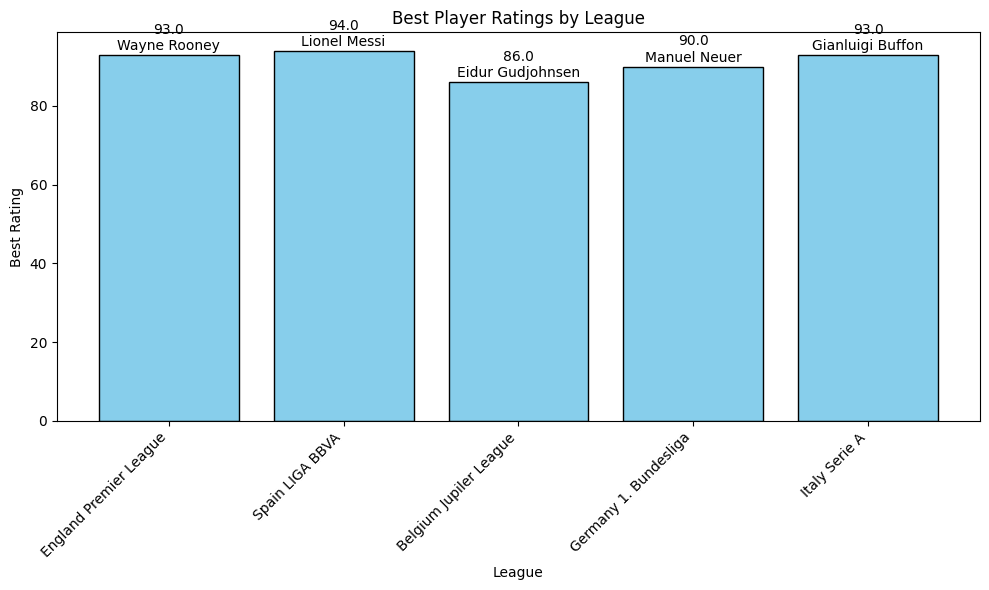

In [ ]:
data = {
    'league': [
        "England Premier League",
        "Spain LIGA BBVA",
        "Belgium Jupiler League",
        "Germany 1. Bundesliga",
        "Italy Serie A"
    ],
    'best_player': [
        "Wayne Rooney",
        "Lionel Messi",
        "Eidur Gudjohnsen",
        "Manuel Neuer",
        "Gianluigi Buffon"
    ],
    'best_rating': [93.0, 94.0, 86.0, 90.0, 93.0]
}

df_results = pd.DataFrame(data)
plt.figure(figsize=(10, 6))
bars = plt.bar(df_results['league'], df_results['best_rating'], color='skyblue', edgecolor='black')
for idx, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.5,
        f"{df_results['best_rating'][idx]}\n{df_results['best_player'][idx]}",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.title("Best Player Ratings by League")
plt.xlabel("League")
plt.ylabel("Best Rating")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


         player_name  overall_rating
0       Lionel Messi            94.0
1  Cristiano Ronaldo            93.0
2     Xavi Hernandez            92.0
3     Gregory Coupet            92.0
4      Iker Casillas            91.0
5      Thierry Henry            91.0
6    Fabio Cannavaro            91.0
7     Andres Iniesta            91.0
8        Luis Suarez            90.0
9             Neymar            90.0


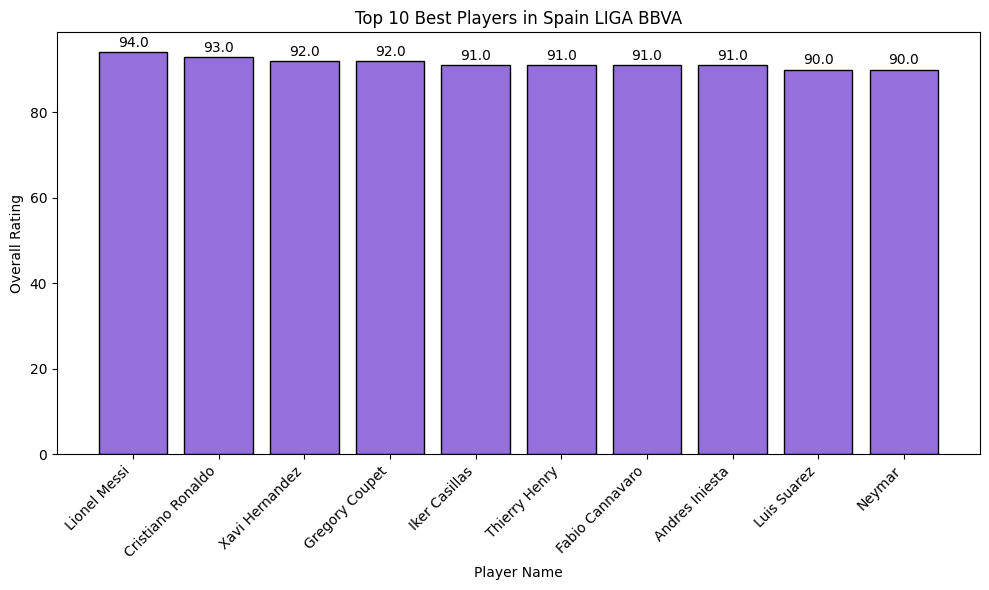

In [ ]:
df_league = pd.read_sql_query("SELECT * FROM League", conn)
df_match = pd.read_sql_query("SELECT * FROM Match", conn)
df_player = pd.read_sql_query("SELECT * FROM Player", conn)
df_player_attr = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)

def find_top_n_players_in_league(league_name, n=10):

    league_row = df_league[df_league['name'] == league_name]
    if league_row.empty:
        print(f"ไม่พบลีก: {league_name}")
        return None
    league_country_id = league_row['country_id'].values[0]
    league_matches = df_match[df_match['country_id'] == league_country_id]

    player_cols = [f'home_player_{i}' for i in range(1, 12)] + [f'away_player_{i}' for i in range(1, 12)]
    player_ids = pd.unique(league_matches[player_cols].values.ravel('K'))
    player_ids = player_ids[~pd.isnull(player_ids)].astype(int)
    if len(player_ids) == 0:
        print("ไม่พบนักเตะในแมตช์ของลีกนี้")
        return None

    df_attr_league = df_player_attr[df_player_attr['player_api_id'].isin(player_ids)]
    if df_attr_league.empty:
        print("ไม่พบข้อมูลสถิติของนักเตะในลีกนี้")
        return None

    df_rating = df_attr_league.groupby('player_api_id')['overall_rating'].max().reset_index()

    df_rating_sorted = df_rating.sort_values(by='overall_rating', ascending=False).head(n)
    df_rating_sorted = df_rating_sorted.merge(df_player[['player_api_id', 'player_name']], on='player_api_id', how='left')
    return df_rating_sorted


top10_spain = find_top_n_players_in_league("Spain LIGA BBVA", n=10)
if top10_spain is None:
    print("ไม่พบข้อมูล Top 10 นักเตะ")
else:
    print(top10_spain[['player_name', 'overall_rating']])

    plt.figure(figsize=(10, 6))
    bars = plt.bar(top10_spain['player_name'], top10_spain['overall_rating'], color='mediumpurple', edgecolor='black')

    for i, row in enumerate(top10_spain.itertuples()):
        plt.text(i, row.overall_rating + 0.5, f"{row.overall_rating:.1f}", ha='center', va='bottom', fontsize=10)

    plt.title("Top 10 Best Players in Spain LIGA BBVA")
    plt.xlabel("Player Name")
    plt.ylabel("Overall Rating")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


Top 10 นักเตะใน Spain LIGA BBVA (โดย Overall Rating สูงสุด):
         player_name  overall_rating
0       Lionel Messi            94.0
1  Cristiano Ronaldo            93.0
2     Xavi Hernandez            92.0
3     Gregory Coupet            92.0
4      Iker Casillas            91.0
5      Thierry Henry            91.0
6    Fabio Cannavaro            91.0
7     Andres Iniesta            91.0
8        Luis Suarez            90.0
9             Neymar            90.0

Top 10 นักเตะพร้อม win rate:
         player_name  overall_rating  win_rate  matches_played
0       Lionel Messi            94.0  0.779116             249
1  Cristiano Ronaldo            93.0  0.767544             228
2     Xavi Hernandez            92.0  0.761905             189
3     Gregory Coupet            92.0  0.333333               6
4      Iker Casillas            91.0  0.745000             200
5      Thierry Henry            91.0  0.897436              39
6    Fabio Cannavaro            91.0  0.655172              2

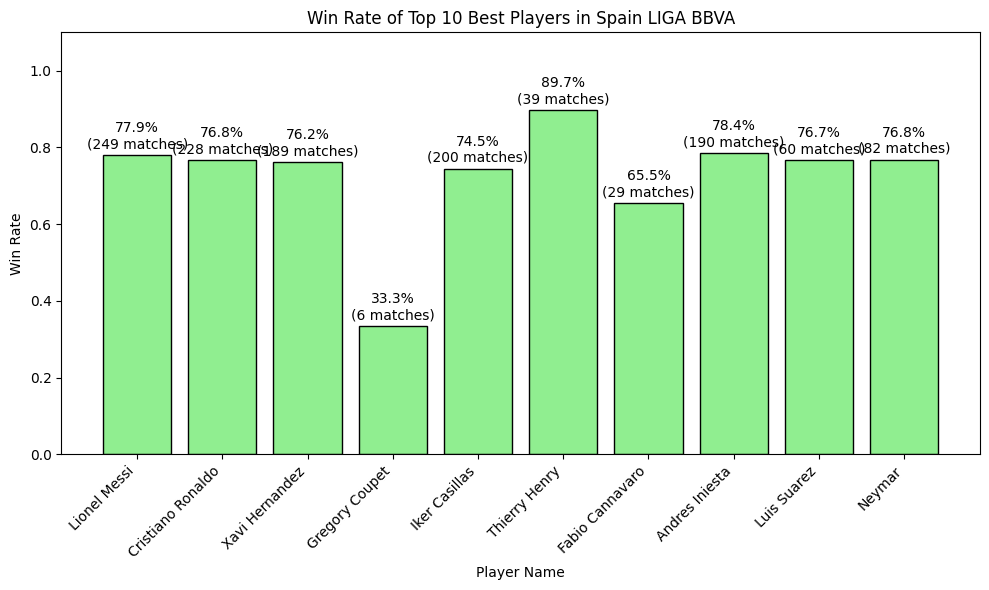

In [ ]:
df_league = pd.read_sql_query("SELECT * FROM League", conn)
df_match = pd.read_sql_query("SELECT * FROM Match", conn)
df_player = pd.read_sql_query("SELECT * FROM Player", conn)
df_player_attr = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)

def find_top_n_players_in_league(league_name, n=10):

    league_row = df_league[df_league['name'] == league_name]
    if league_row.empty:
        print(f"ไม่พบลีก: {league_name}")
        return None
    league_country_id = league_row['country_id'].values[0]
    league_matches = df_match[df_match['country_id'] == league_country_id]

    player_cols = [f'home_player_{i}' for i in range(1, 12)] + [f'away_player_{i}' for i in range(1, 12)]
    league_player_ids = pd.unique(league_matches[player_cols].values.ravel('K'))
    league_player_ids = league_player_ids[~pd.isnull(league_player_ids)].astype(int)
    if len(league_player_ids) == 0:
        print("ไม่พบนักเตะในแมตช์ของลีกนี้")
        return None
    df_attr_league = df_player_attr[df_player_attr['player_api_id'].isin(league_player_ids)]
    if df_attr_league.empty:
        print("ไม่พบข้อมูลสถิติของนักเตะในลีกนี้")
        return None

    df_rating = df_attr_league.groupby('player_api_id')['overall_rating'].max().reset_index()
    df_rating_sorted = df_rating.sort_values(by='overall_rating', ascending=False).head(n)
    df_rating_sorted = df_rating_sorted.merge(df_player[['player_api_id', 'player_name']], on='player_api_id', how='left')
    return df_rating_sorted, league_country_id, league_matches

top10_spain, spain_country_id, spanish_matches = find_top_n_players_in_league("Spain LIGA BBVA", n=10)
if top10_spain is None:
    print("ไม่พบข้อมูล Top 10 นักเตะ")
else:
    print("Top 10 นักเตะใน Spain LIGA BBVA (โดย Overall Rating สูงสุด):")
    print(top10_spain[['player_name', 'overall_rating']])

def get_player_win_rate(player_id, matches_df):
    cols = [f'home_player_{i}' for i in range(1, 12)] + [f'away_player_{i}' for i in range(1, 12)]
    mask = matches_df[cols].isin([player_id]).any(axis=1)
    player_matches = matches_df[mask]
    if player_matches.empty:
        return 0, 0
    wins = 0

    for _, row in player_matches.iterrows():
        home_players = row[[f'home_player_{i}' for i in range(1, 12)]].values
        away_players = row[[f'away_player_{i}' for i in range(1, 12)]].values

        if player_id in home_players:
            if row['home_team_goal'] > row['away_team_goal']:
                wins += 1
        elif player_id in away_players:
            if row['away_team_goal'] > row['home_team_goal']:
                wins += 1
    win_rate = wins / len(player_matches)
    return win_rate, len(player_matches)

win_rates = []
matches_played = []
for pid in top10_spain['player_api_id']:
    wr, mp = get_player_win_rate(pid, spanish_matches)
    win_rates.append(wr)
    matches_played.append(mp)

top10_spain['win_rate'] = win_rates
top10_spain['matches_played'] = matches_played

print("\nTop 10 นักเตะพร้อม win rate:")
print(top10_spain[['player_name', 'overall_rating', 'win_rate', 'matches_played']])

plt.figure(figsize=(10, 6))
bars = plt.bar(top10_spain['player_name'], top10_spain['win_rate'], color='lightgreen', edgecolor='black')

for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 0.01,
        f"{top10_spain['win_rate'].iloc[i]*100:.1f}%\n({top10_spain['matches_played'].iloc[i]} matches)",
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.title("Win Rate of Top 10 Best Players in Spain LIGA BBVA")
plt.xlabel("Player Name")
plt.ylabel("Win Rate")
plt.ylim(0, 1.1)  # ตั้งให้แกน y มีค่า 0-110% เพื่อให้มีที่ว่างสำหรับ label
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Messi ID: 30981
จำนวนแมตช์ที่ Messi ลงเล่น: 249
ค่าเฉลี่ย rating ของ Messi แยกตามผลการแข่งขัน:
 messi_result
Draw    92.424242
Loss    92.772727
Win     92.381443
Name: overall_rating, dtype: float64


<ipython-input-14-b6bb89ec321c>:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=messi_matches_merged, x='messi_result', y='overall_rating', palette='pastel')


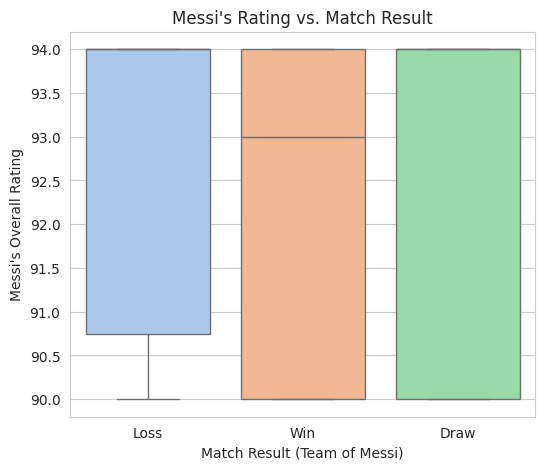

In [14]:
df_player = pd.read_sql_query("SELECT * FROM Player", conn)
df_player_attr = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)
df_match = pd.read_sql_query("SELECT * FROM Match", conn)



# -------------------------------------------------------------
# 2) หา player_api_id ของ Lionel Messi
# -------------------------------------------------------------
messi_row = df_player[df_player['player_name'] == 'Lionel Messi']
if messi_row.empty:
    raise ValueError("ไม่พบ Lionel Messi ในตาราง Player")
messi_id = messi_row.iloc[0]['player_api_id']
print("Messi ID:", messi_id)

# -------------------------------------------------------------
# 3) กรองแมตช์ที่ Messi ลงสนาม
# -------------------------------------------------------------
# สร้าง list ของคอลัมน์ผู้เล่นทั้ง 22 คน
player_cols = [f'home_player_{i}' for i in range(1, 12)] + [f'away_player_{i}' for i in range(1, 12)]

# เลือกเฉพาะแถวที่มี Messi_id ใน 22 คอลัมน์
mask_messi = df_match[player_cols].isin([messi_id]).any(axis=1)
messi_matches = df_match[mask_messi].copy()
print("จำนวนแมตช์ที่ Messi ลงเล่น:", len(messi_matches))

# -------------------------------------------------------------
# 4) ฟังก์ชันหาผลการแข่งขัน (Win/Draw/Loss) สำหรับทีม Messi
# -------------------------------------------------------------
def get_messi_result(row, messi_id):
    # ดูว่า Messi อยู่ฝั่งเจ้าบ้านหรือทีมเยือน
    home_players = row[[f'home_player_{i}' for i in range(1, 12)]].values
    away_players = row[[f'away_player_{i}' for i in range(1, 12)]].values

    home_goals = row['home_team_goal']
    away_goals = row['away_team_goal']

    if messi_id in home_players:
        # อยู่ทีมเหย้า
        if home_goals > away_goals:
            return 'Win'
        elif home_goals == away_goals:
            return 'Draw'
        else:
            return 'Loss'
    else:
        # อยู่ทีมเยือน
        if away_goals > home_goals:
            return 'Win'
        elif away_goals == home_goals:
            return 'Draw'
        else:
            return 'Loss'

# สร้างคอลัมน์ 'messi_result' ระบุว่าแมตช์นี้ทีม Messi ชนะ/เสมอ/แพ้
messi_matches['messi_result'] = messi_matches.apply(lambda row: get_messi_result(row, messi_id), axis=1)

# -------------------------------------------------------------
# 5) เตรียมข้อมูล rating ของ Messi ตามวันที่ (Player_Attributes)
# -------------------------------------------------------------
# กรองเฉพาะ row ของ Messi ใน df_player_attr
df_messi_attr = df_player_attr[df_player_attr['player_api_id'] == messi_id].copy()
# แปลงคอลัมน์ date เป็น datetime
df_messi_attr['date'] = pd.to_datetime(df_messi_attr['date'])
# เรียงตามวันที่ล่าสุด -> เก่าสุด (เผื่อใช้ merge_asof)
df_messi_attr.sort_values(by='date', inplace=True)

# -------------------------------------------------------------
# 6) จับคู่วันแข่งใน messi_matches กับ rating ของ Messi ใกล้เคียงวันนั้น (ไม่เกินวันแข่ง)
# -------------------------------------------------------------
# แปลง date ของ Match เป็น datetime เช่นกัน
messi_matches['match_date'] = pd.to_datetime(messi_matches['date'])  # สมมติคอลัมน์ชื่อ 'date'
messi_matches.sort_values(by='match_date', inplace=True)

# ใช้ pandas.merge_asof เพื่อจับคู่ค่า overall_rating ที่มี date <= match_date
# โดยค่า default จะจับค่าสุดท้ายก่อนหรือเท่ากับ match_date
messi_matches_merged = pd.merge_asof(
    messi_matches,
    df_messi_attr[['date','overall_rating']].rename(columns={'date':'attr_date'}),
    left_on='match_date',
    right_on='attr_date',
    direction='backward'
)

# ตอนนี้จะมีคอลัมน์ overall_rating ของ Messi ใกล้เคียงวันแข่งอยู่ใน messi_matches_merged
# บางแมตช์อาจไม่มี rating หาก match_date < attr_date ที่เล็กที่สุด

# -------------------------------------------------------------
# 7) สรุปผล: ดู rating เฉลี่ยใน Win/Draw/Loss
# -------------------------------------------------------------
grouped = messi_matches_merged.groupby('messi_result')['overall_rating'].mean()
print("ค่าเฉลี่ย rating ของ Messi แยกตามผลการแข่งขัน:\n", grouped)

# -------------------------------------------------------------
# 8) วาด boxplot rating ของ Messi ตาม Win/Draw/Loss
# -------------------------------------------------------------
sns.set_style('whitegrid')
plt.figure(figsize=(6, 5))
sns.boxplot(data=messi_matches_merged, x='messi_result', y='overall_rating', palette='pastel')
plt.title("Messi's Rating vs. Match Result")
plt.xlabel("Match Result (Team of Messi)")
plt.ylabel("Messi's Overall Rating")
plt.show()


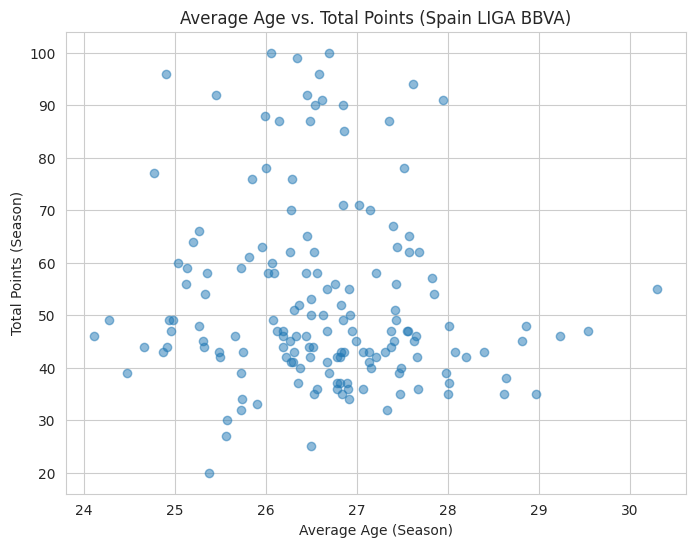

Correlation between Average Age and Total Points = -0.0910


In [19]:


df_league = pd.read_sql_query("SELECT * FROM League", conn)
df_match  = pd.read_sql_query("SELECT * FROM Match", conn)
df_player = pd.read_sql_query("SELECT * FROM Player", conn)
df_team   = pd.read_sql_query("SELECT * FROM Team", conn)

df_spain_league = df_league[df_league['name'] == "Spain LIGA BBVA"]
if df_spain_league.empty:
    raise ValueError("ไม่พบข้อมูลลีก Spain LIGA BBVA")

spain_league_id = df_spain_league.iloc[0]['id']
df_spain = df_match[df_match['league_id'] == spain_league_id].copy()

def calculate_age(born, match_date):

    return match_date.year - born.year - ((match_date.month, match_date.day) < (born.month, born.day))

df_player['birthday'] = pd.to_datetime(df_player['birthday'])


player_bday_dict = dict(zip(df_player['player_api_id'], df_player['birthday']))

df_spain['match_date'] = pd.to_datetime(df_spain['date'])  # ในบางเวอร์ชันคอลัมน์ชื่อ date

home_cols = [f'home_player_{i}' for i in range(1, 12)]
away_cols = [f'away_player_{i}' for i in range(1, 12)]

def get_avg_age(row, player_cols):
    match_d = row['match_date']
    player_ids = row[player_cols].values
    ages = []
    for pid in player_ids:
        if pd.isnull(pid):
            continue
        pid = int(pid)
        if pid in player_bday_dict:
            birthday = player_bday_dict[pid]
            age = calculate_age(birthday, match_d)
            ages.append(age)
    if len(ages) == 0:
        return np.nan
    return np.mean(ages)

df_spain['home_avg_age'] = df_spain.apply(lambda row: get_avg_age(row, home_cols), axis=1)
df_spain['away_avg_age'] = df_spain.apply(lambda row: get_avg_age(row, away_cols), axis=1)

df_spain['home_points'] = df_spain.apply(
    lambda row: 3 if row['home_team_goal'] > row['away_team_goal']
                else (1 if row['home_team_goal'] == row['away_team_goal'] else 0),
    axis=1
)
df_spain['away_points'] = df_spain.apply(
    lambda row: 3 if row['away_team_goal'] > row['home_team_goal']
                else (1 if row['away_team_goal'] == row['home_team_goal'] else 0),
    axis=1
)

home_df = df_spain.groupby(['season', 'home_team_api_id']).agg({
    'home_points': 'sum',
    'home_avg_age': 'mean'
}).reset_index()
home_df.rename(columns={'home_team_api_id':'team_api_id',
                        'home_points':'points_sum',
                        'home_avg_age':'avg_age'}, inplace=True)


away_df = df_spain.groupby(['season', 'away_team_api_id']).agg({
    'away_points': 'sum',
    'away_avg_age': 'mean'
}).reset_index()
away_df.rename(columns={'away_team_api_id':'team_api_id',
                        'away_points':'points_sum',
                        'away_avg_age':'avg_age'}, inplace=True)

df_age_points = pd.concat([home_df, away_df], ignore_index=True)

df_age_points = df_age_points.groupby(['season', 'team_api_id']).agg({
    'points_sum': 'sum',
    'avg_age': 'mean'
}).reset_index()

df_age_points.rename(columns={'points_sum':'total_points', 'avg_age':'avg_age_season'}, inplace=True)

plt.figure(figsize=(8,6))
plt.scatter(df_age_points['avg_age_season'], df_age_points['total_points'], alpha=0.5)
plt.xlabel("Average Age (Season)")
plt.ylabel("Total Points (Season)")
plt.title("Average Age vs. Total Points (Spain LIGA BBVA)")
plt.grid(True)
plt.show()

corr = df_age_points[['avg_age_season','total_points']].corr().iloc[0,1]
print(f"Correlation between Average Age and Total Points = {corr:.4f}")


Correlation (buildUpPlaySpeed vs total_goals) = 0.019
Correlation (buildUpPlayPassing vs total_goals) = 0.310


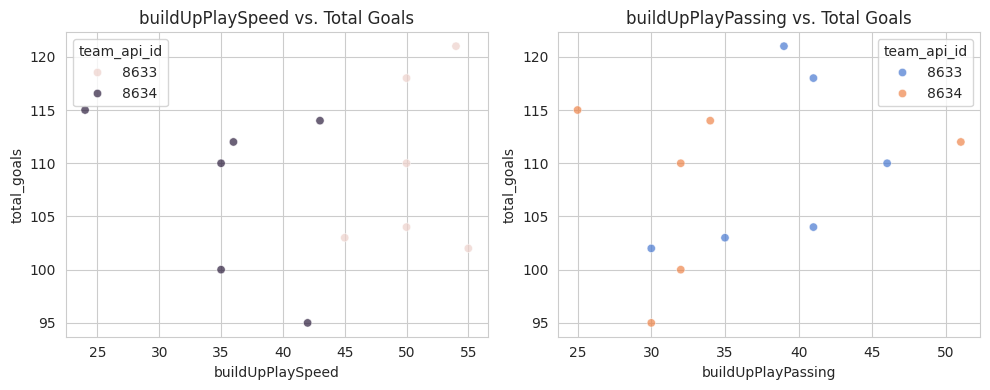

       season  team_api_id  total_goals  buildUpPlaySpeed  buildUpPlayPassing
0   2010/2011         8633          102                55                  30
1   2010/2011         8634           95                42                  30
2   2011/2012         8633          121                54                  39
3   2011/2012         8634          114                43                  34
4   2012/2013         8633          103                45                  35
5   2012/2013         8634          115                24                  25
6   2013/2014         8633          104                50                  41
7   2013/2014         8634          100                35                  32
8   2014/2015         8633          118                50                  41
9   2014/2015         8634          110                35                  32
10  2015/2016         8633          110                50                  46
11  2015/2016         8634          112                36       

In [25]:
df_match = pd.read_sql_query("SELECT * FROM Match", conn)
df_team = pd.read_sql_query("SELECT * FROM Team", conn)
df_team_attr = pd.read_sql_query("SELECT * FROM Team_Attributes", conn)

barca_row = df_team[df_team['team_long_name'] == 'FC Barcelona']
if barca_row.empty:
    raise ValueError("ไม่พบทีม FC Barcelona ในตาราง Team")
barca_id = barca_row.iloc[0]['team_api_id']

madrid_row = df_team[df_team['team_long_name'] == 'Real Madrid CF']
if madrid_row.empty:
    raise ValueError("ไม่พบทีม Real Madrid CF ในตาราง Team")
madrid_id = madrid_row.iloc[0]['team_api_id']

team_ids = [barca_id, madrid_id]

home_goals = df_match.groupby(['season','home_team_api_id'])['home_team_goal'].sum().reset_index()
home_goals.rename(columns={'home_team_api_id':'team_api_id','home_team_goal':'goals_scored'}, inplace=True)

away_goals = df_match.groupby(['season','away_team_api_id'])['away_team_goal'].sum().reset_index()
away_goals.rename(columns={'away_team_api_id':'team_api_id','away_team_goal':'goals_scored'}, inplace=True)

df_goals = pd.concat([home_goals, away_goals], ignore_index=True)
df_goals = df_goals.groupby(['season','team_api_id'])['goals_scored'].sum().reset_index()
df_goals.rename(columns={'goals_scored':'total_goals'}, inplace=True)

df_goals = df_goals[df_goals['team_api_id'].isin(team_ids)].copy()

df_team_attr['date'] = pd.to_datetime(df_team_attr['date'])
df_team_attr['year'] = df_team_attr['date'].dt.year

def get_start_year(season_str):
    return int(season_str.split('/')[0])

df_goals['start_year'] = df_goals['season'].apply(get_start_year)

df_team_attr_filtered = df_team_attr[['team_api_id','date','year',
                                      'buildUpPlaySpeed','buildUpPlayPassing']].copy()

df_team_attr_filtered = df_team_attr_filtered[df_team_attr_filtered['team_api_id'].isin(team_ids)]

df_team_attr_filtered.sort_values(by=['team_api_id','year','date'], inplace=True)
df_team_attr_filtered = df_team_attr_filtered.groupby(['team_api_id','year']).last().reset_index()

df_merged = pd.merge(df_goals, df_team_attr_filtered,
                     left_on=['team_api_id','start_year'],
                     right_on=['team_api_id','year'],
                     how='inner')

corr_speed = df_merged[['buildUpPlaySpeed','total_goals']].corr().iloc[0,1]
corr_pass  = df_merged[['buildUpPlayPassing','total_goals']].corr().iloc[0,1]

print(f"Correlation (buildUpPlaySpeed vs total_goals) = {corr_speed:.3f}")
print(f"Correlation (buildUpPlayPassing vs total_goals) = {corr_pass:.3f}")

sns.set_style('whitegrid')
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
sns.scatterplot(data=df_merged, x='buildUpPlaySpeed', y='total_goals',
                hue='team_api_id', alpha=0.7)
plt.title("buildUpPlaySpeed vs. Total Goals")

plt.subplot(1,2,2)
sns.scatterplot(data=df_merged, x='buildUpPlayPassing', y='total_goals',
                hue='team_api_id', alpha=0.7, palette='muted')
plt.title("buildUpPlayPassing vs. Total Goals")

plt.tight_layout()
plt.show()

print(df_merged[['season','team_api_id','total_goals','buildUpPlaySpeed','buildUpPlayPassing']])


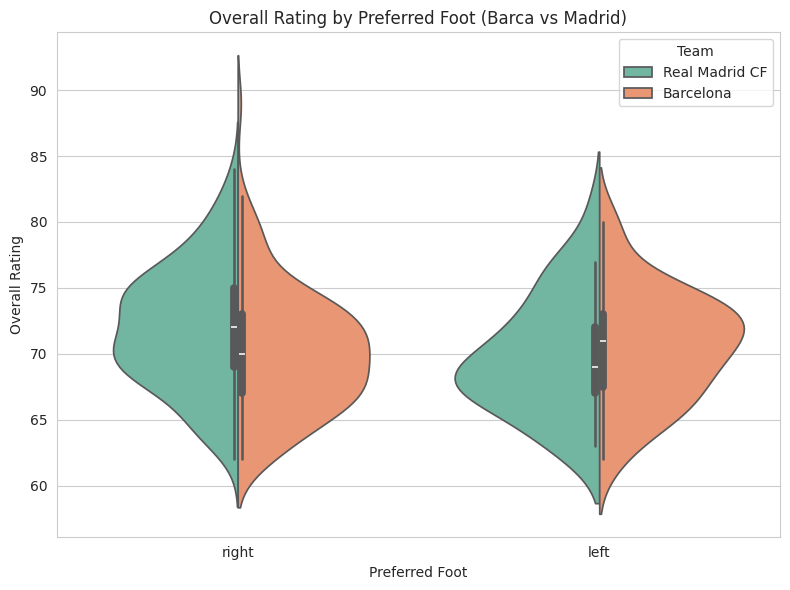

team            preferred_foot
Barcelona       left               35
                right             117
Real Madrid CF  left               36
                right             111
Name: player_id, dtype: int64


In [27]:
df_team = pd.read_sql_query("SELECT * FROM Team", conn)
df_match = pd.read_sql_query("SELECT * FROM Match", conn)
df_player_attr = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)

barca_row = df_team[df_team['team_long_name'] == 'FC Barcelona']
if barca_row.empty:
    raise ValueError("ไม่พบทีม FC Barcelona")
barca_id = barca_row.iloc[0]['team_api_id']

madrid_row = df_team[df_team['team_long_name'] == 'Real Madrid CF']
if madrid_row.empty:
    raise ValueError("ไม่พบทีม Real Madrid CF")
madrid_id = madrid_row.iloc[0]['team_api_id']

home_cols = [f'home_player_{i}' for i in range(1, 12)]
away_cols = [f'away_player_{i}' for i in range(1, 12)]

def get_players_for_team(df, team_id):
    df_team_matches = df[(df['home_team_api_id'] == team_id) | (df['away_team_api_id'] == team_id)]
    player_cols = home_cols + away_cols
    players = pd.unique(df_team_matches[player_cols].values.ravel('K'))
    players = players[~pd.isnull(players)].astype(int)
    return set(players)

barca_players = get_players_for_team(df_match, barca_id)
madrid_players = get_players_for_team(df_match, madrid_id)


player_team_map = {}
for pid in barca_players:
    player_team_map[pid] = 'Barcelona'
for pid in madrid_players:
    if pid in player_team_map and player_team_map[pid] != 'Real Madrid CF':
        player_team_map[pid] = 'Both'
    else:
        player_team_map[pid] = 'Real Madrid CF'

df_player_attr.sort_values(by=['player_api_id','date'], inplace=True)
df_player_attr_latest = df_player_attr.groupby('player_api_id').last().reset_index()

data_list = []
for idx, row in df_player_attr_latest.iterrows():
    pid = row['player_api_id']
    if pid in player_team_map:
        team_label = player_team_map[pid]
        if team_label == 'Both':

            continue
        foot = row['preferred_foot']
        rating = row['overall_rating']
        data_list.append((pid, team_label, foot, rating))

df_plot = pd.DataFrame(data_list, columns=['player_id','team','preferred_foot','overall_rating'])

plt.figure(figsize=(8,6))
sns.set_style('whitegrid')

sns.violinplot(
    data=df_plot,
    x='preferred_foot',
    y='overall_rating',
    hue='team',
    split=True,
    palette='Set2'
)
plt.title("Overall Rating by Preferred Foot (Barca vs Madrid)")
plt.xlabel("Preferred Foot")
plt.ylabel("Overall Rating")
plt.legend(title="Team")
plt.tight_layout()
plt.show()

print(df_plot.groupby(['team','preferred_foot'])['player_id'].count())
